In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

In [2]:
results_path = '../Metrics/Results/'

In [3]:
csv_paths = sorted(glob(results_path + '*'))

In [4]:
def get_method(name):
    s = name
    s = s.split('/')[1]
    s = s.split('-', 1)[1]

    if s.startswith('tsne'):
        return s[:7]
    elif s.startswith('dtsne'):
        return 'dtsne'
    elif s.startswith('pca'):
        return s[:6]
    else:
        return s.split('_')[0]


In [5]:
df_metrics = pd.DataFrame()
for p in csv_paths:
    df = pd.read_csv(p)
    df = df.drop(['spat_kl', 'stab_kl'], axis=1)  # Bad metric
    # Extract dataset and method into own column
    df.columns = np.concatenate([['name'], df.columns.values[1:]])
    df['dataset'] = df['name'].str.split('_', 1).str[0].str.extract(r'.*/(.*)-.*')
    df['method'] = df['name'].apply(get_method)
    df = df.set_index('name')
    
    # Average nh and np metrics 
    nh_cols = [c for c in df.columns if 'spat_nh_' in c]
    df['spat_nh_mean'] = np.mean(df[nh_cols], axis=1)
#     df = df.drop(nh_cols, axis=1)
    np_cols = [c for c in df.columns if 'spat_np_' in c]
    df['spat_np_mean'] = np.mean(df[np_cols], axis=1)
#     df = df.drop(np_cols, axis=1)
    df_metrics = pd.concat([df_metrics, df])

In [6]:
np_cols = [c for c in df.columns if 'spat_np_' in c]
np.mean(df[np_cols], axis=1)

name
Output/walk-AE_10f_10f_2f_20ep.csv      0.481985
Output/walk-VAE_100f_10f_2f_20ep.csv    0.481074
Output/walk-tsne_s1_30p.csv             0.476209
Output/walk-tsne_s4_30p.csv             0.462251
Output/walk-dtsne_100p_0-01l.csv        0.471319
Output/walk-pca_s1.csv                  0.483420
Output/walk-pca_s4.csv                  0.483167
dtype: float64

In [7]:
vs = []
indexes = []
for i, df in df_metrics.groupby('method'):
#     print(i), display(df)
    indexes.append(i)
    vs.append(np.mean(df, axis=0))

df_per_method = pd.DataFrame(vs, indexes)
df_per_method = df_per_method
# df_per_method.index = indexes
df_per_method = df_per_method.reindex(['AE', 'C2AE', 'VAE', 'C2VAE', 'tsne_s1', 'tsne_s4', 'dtsne', 'pca_s1', 'pca_s4'])

In [8]:
# Organize order before generating matrix
cols = ['stab_pearson', 'stab_spearman' , 'stab_kendall', 'stab_stress_n', 'stab_stress_s']
df_stab = df_per_method[cols]

cols = ['spat_pearson', 'spat_spearman' , 'spat_kendall', 'spat_stress_n', 'spat_stress_s']
df_spat_dists = df_per_method[cols]

cols = ['spat_nh_mean', 'spat_np_mean']
df_spat_neigh = df_per_method[cols]

blank = pd.DataFrame(np.zeros((len(df_stab), 1)), index=df_stab.index, columns=[' '])

df = pd.concat([df_stab, blank, df_spat_dists, blank, df_spat_neigh], axis=1)
df = df.drop(['C2AE', 'C2VAE'])

df

,stab_pearson,stab_spearman,stab_kendall,stab_stress_n,stab_stress_s,,spat_pearson,spat_spearman,spat_kendall,spat_stress_n,spat_stress_s,,spat_nh_mean,spat_np_mean
AE,0.486771,0.672234,0.564096,0.511469,1.026457,0.0,0.740004,0.804774,0.659133,0.231429,0.519991,0.0,0.050291,0.471675
VAE,0.549811,0.685276,0.581146,0.458045,0.900377,0.0,0.760023,0.803864,0.659512,0.225638,0.479954,0.0,0.050798,0.470478
tsne_s1,0.020008,0.002021,0.002212,17.835451,1.959983,0.0,0.477081,0.577056,0.442850,0.621005,1.045838,0.0,0.050301,0.471732
tsne_s4,0.329527,0.487952,0.386461,0.928513,1.340946,0.0,0.660217,0.704072,0.531389,0.609990,0.679565,0.0,0.044171,0.454743
dtsne,0.184220,0.192488,0.147888,3.320041,1.631561,0.0,0.609111,0.675699,0.514559,0.514577,0.781778,0.0,0.041477,0.457806
pca_s1,0.312698,0.453133,0.354881,0.926273,1.374603,0.0,0.784056,0.810542,0.669136,0.185815,0.431887,0.0,0.048245,0.476409
pca_s4,0.586277,0.673701,0.580383,0.389519,0.827446,0.0,0.778645,0.805928,0.665666,0.192350,0.442709,0.0,0.048357,0.475133


In [9]:
def plot_matrix(ax, df, cell_text=False, invert_colormap=[], title=None, xticks=True, show=True):
    
    matrix = df.values
    metric_ids = df.columns
    dataset_ids = df.index

    # The colormap range is independent for each column
    for i, metric in enumerate(metric_ids):
        # Make all rows invalid (fill with 1) except the target one (col)
        m = np.ones_like(matrix)
        m[:, i] = 0
        masked = np.ma.masked_array(matrix, m)
        if metric in invert_colormap:
            colormap = plt.cm.YlGn
        else:
            colormap = plt.cm.YlGn_r

        if(np.sum(masked) != 0.0):  # Check if spacer column
            ax.matshow(masked, cmap=colormap, aspect='auto')

    # Ticks, labels and grids
    if xticks:
        ax.set_xticklabels(metric_ids, rotation='vertical')
        ax.set_xticks(range(len(metric_ids)), minor=False)
    else:
        ax.set_xticklabels([])
    ax.set_yticklabels(dataset_ids)
    ax.set_yticks(range(len(dataset_ids)), minor=False)
    ax.set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor=True)
    ax.set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor=True)
#     ax.grid(which='minor', color='#FFFFFF', linestyle='-', linewidth=4)
    ax.tick_params(axis=u'both', which=u'both', length=0)

    x_start = 0.0
    x_end = len(metric_ids)
    y_start = 0.0
    y_end = len(dataset_ids)

    # Add the text
    fontsize = 9
    if cell_text:
        jump_x = (x_end - x_start) / (2.0 * len(metric_ids))
        jump_y = (y_end - y_start) / (2.0 * len(dataset_ids))
        x_positions = np.linspace(start=x_start - 0.5, stop=x_end - 0.5, num=len(metric_ids), endpoint=False)
        y_positions = np.linspace(start=y_start - 0.5, stop=y_end - 0.5, num=len(dataset_ids), endpoint=False)

        for y_index, y in enumerate(y_positions):
            for x_index, x in enumerate(x_positions):
                if np.sum(matrix[:, x_index]) != 0.0:  # Don't display text in spacer column
                    label = "{0:.5f}".format(matrix[y_index][x_index])[:6]#.lstrip('0')
                    text_x = x + jump_x
                    text_y = y + jump_y
                    color = 0
                    if metric_ids[x_index] in invert_colormap:
                        color = not color

                    if matrix[y_index][x_index] < matrix[:, x_index].min() + (matrix[:, x_index].max() - matrix[:, x_index].min()) * .3:
                        color = not color
                    color = 'white' if color else 'black' 
                    ax.text(text_x, text_y, label, color=color, ha='center', va='center', fontsize=fontsize)

    if title is not None:
        ax.set_ylabel(title, labelpad=10, fontweight='bold')

    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    if show:
        plt.show()

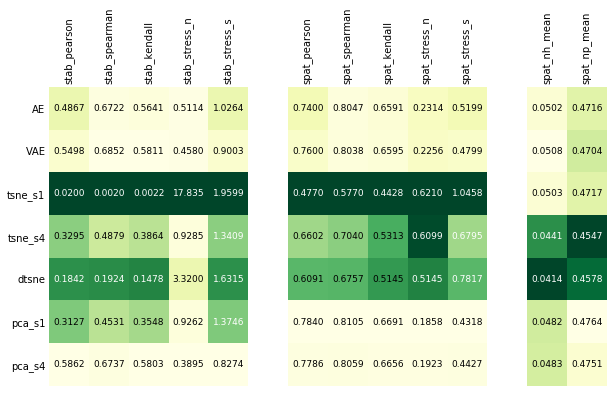

In [10]:
fig = plt.figure(figsize=(10,5.5))
ax = fig.add_subplot(111)
plot_matrix(ax, df, cell_text=True,
            invert_colormap=['stab_stress_n', 'stab_stress_s', 'spat_stress_n', 'spat_stress_s'])
fig.tight_layout()
fig.savefig('Figs/aggregate_matrix.svg')
# fig.savefig('Figs/all_matrix.png')

In [11]:
def plot_lines(ax, df, title=''):
    
    df.columns = df.columns.str.strip('spat_np_')
    n_timesteps = len(df.columns) - 2
    
    colors = []
    for index in df.index.str.split('_').str[0]:
        if 'AE' in index:
            colors.append([1,0,0,1])
        if 'tsne' in index:
            colors.append([.2,.7,.3,1])
        if 'pca' in index:
            colors.append([0,0,1,1])
    
    for line, index, color in zip(df.values, df.index, colors):
        avg = np.mean(line)
        label = '{:.4f} {}'.format(avg, index)
        if len(label) > 18:
            label = label[:18] + '...'
        l = ax.plot(line, c=color, label=label, zorder=avg)

    ax.set_ylabel('Intersection')
    ax.set_xlabel('Size of neighborhood (% of total number of items)')

    ax.set_xlim(0, n_timesteps-1)
    ax.set_xticks([0, (n_timesteps-1)/2, n_timesteps-1], ('1', str(int((n_timesteps)/2)), str(n_timesteps)))
    ax.legend()
    ax.set_title(title)
    
    # Re-sort legend
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: -float(t[0].split(' ')[0])))
    ax.legend(handles, labels)

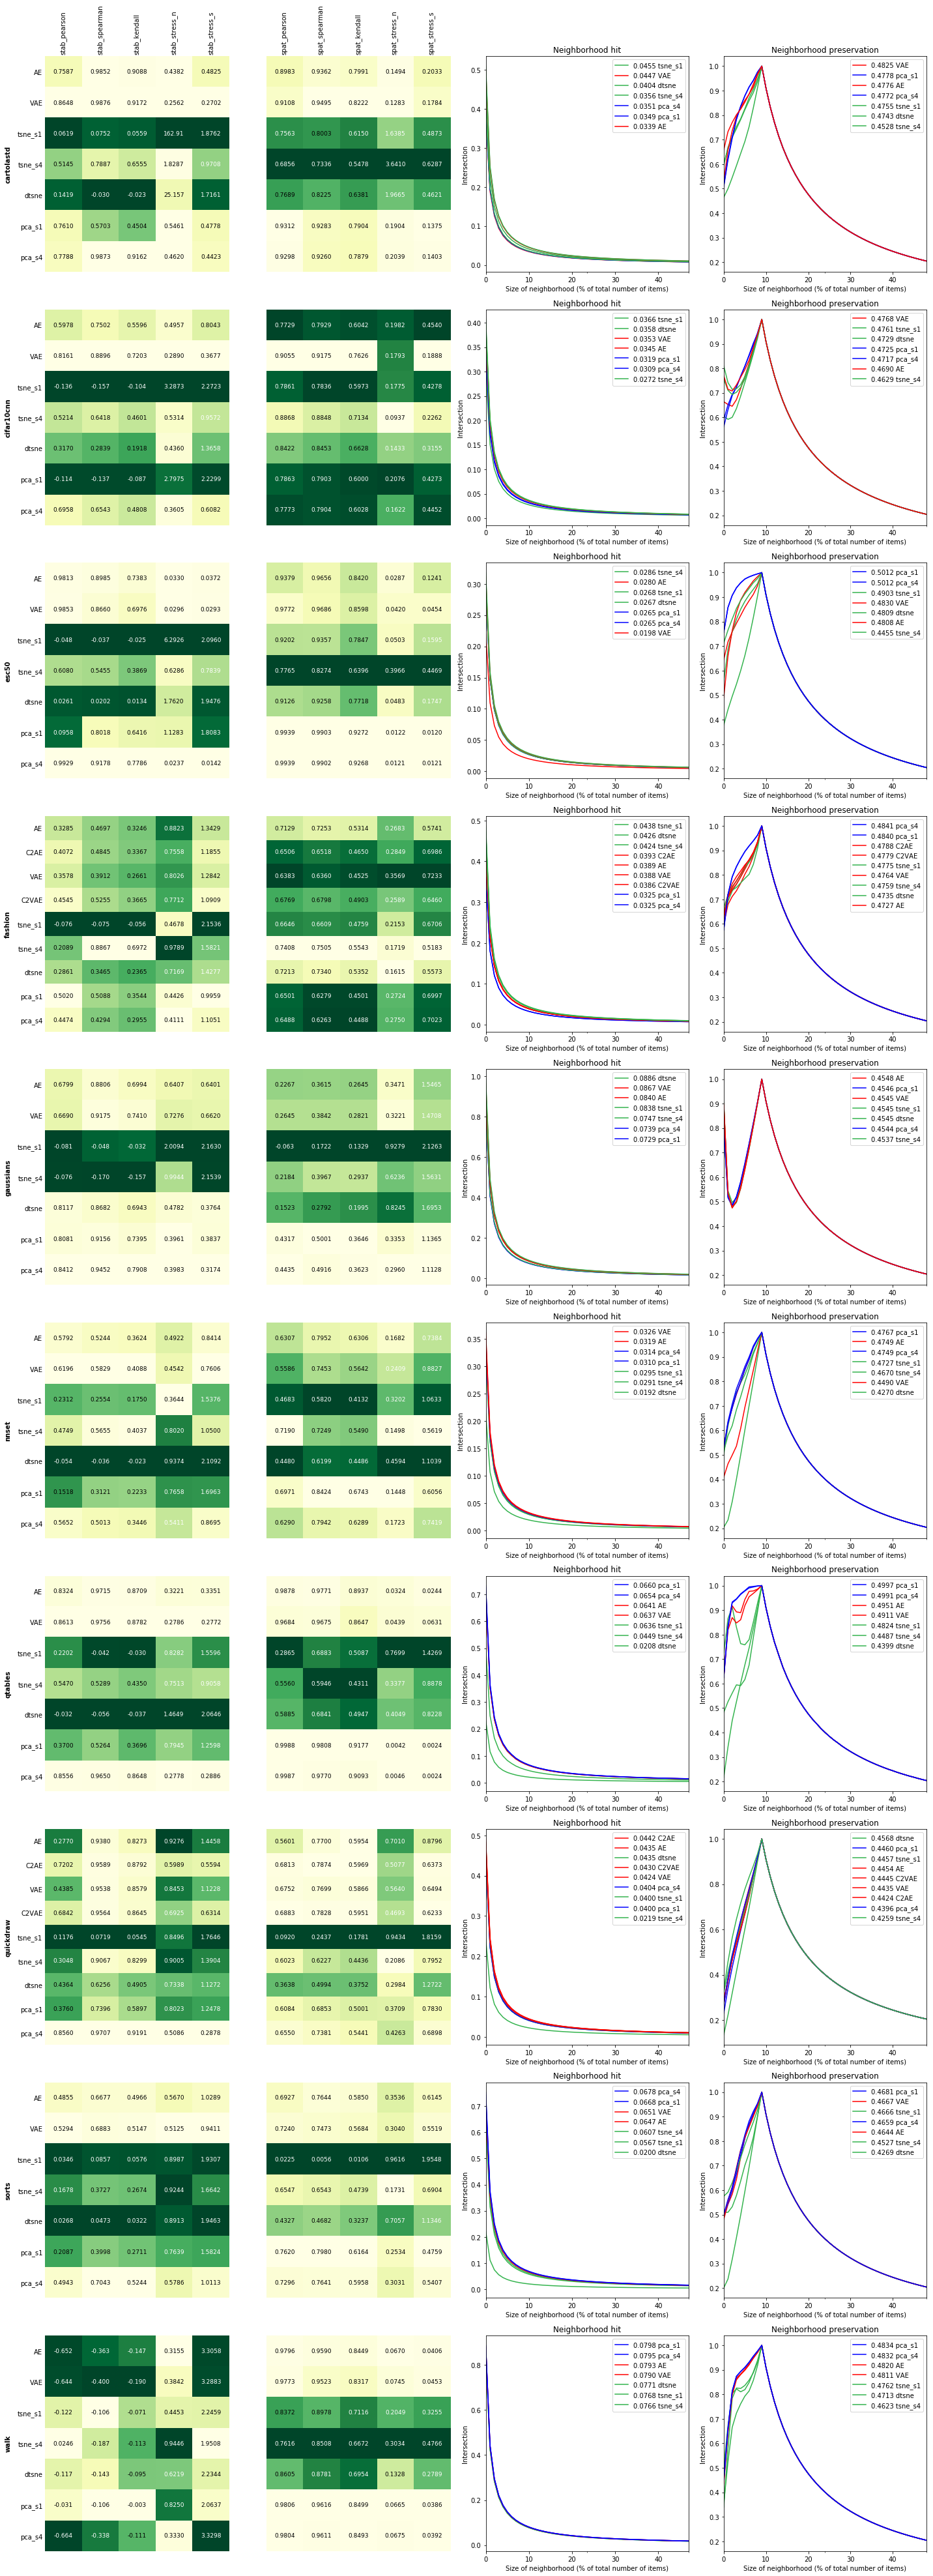

In [12]:
nrows = len(csv_paths)
fig, axes = plt.subplots(figsize=(20, nrows*5.5), nrows=nrows, ncols=3, 
                         gridspec_kw={'width_ratios': [2, 1, 1]})
    
for i, (dataset, df) in enumerate(df_metrics.groupby('dataset')):
    # Arrange matrix before ploting
    df = df.set_index('method')
    if 'C2AE' in df.index:
        df = df.reindex(['AE', 'C2AE', 'VAE', 'C2VAE', 'tsne_s1', 'tsne_s4', 'dtsne', 'pca_s1', 'pca_s4'])
    else:
        df = df.reindex(['AE', 'VAE', 'tsne_s1', 'tsne_s4', 'dtsne', 'pca_s1', 'pca_s4'])
 
    cols = ['stab_pearson', 'stab_spearman' , 'stab_kendall', 'stab_stress_n', 'stab_stress_s']
    df_stab = df[cols]
    cols = ['spat_pearson', 'spat_spearman' , 'spat_kendall', 'spat_stress_n', 'spat_stress_s']
    df_spat_dists = df[cols]
    blank = pd.DataFrame(np.zeros((len(df_stab), 1)), index=df_stab.index, columns=[' '])
    df_d = pd.concat([df_stab, blank, df_spat_dists], axis=1)
    
    xticks = True if i == 0 else False
    plot_matrix(axes[i, 0], df_d, title=dataset, cell_text=True, show=False, xticks=xticks,
                invert_colormap=['stab_stress_n', 'stab_stress_s', 'spat_stress_n', 'spat_stress_s'])

    plot_lines(axes[i, 1], df[nh_cols], 'Neighborhood hit')
    plot_lines(axes[i, 2], df[np_cols], 'Neighborhood preservation')

fig.tight_layout()
fig.savefig('Figs/individual_plots.svg')